## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## Step 1 - Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
from ipywidgets import interact, interactive, fixed
from moviepy.editor import VideoFileClip
from calibrator import CameraCalibrator
%matplotlib inline

not found


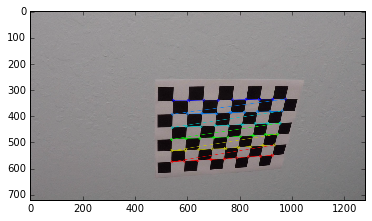

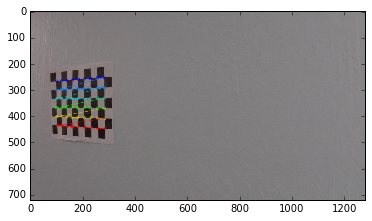

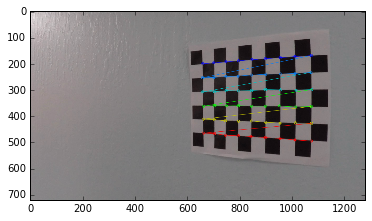

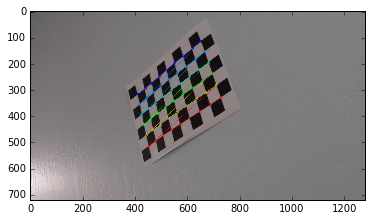

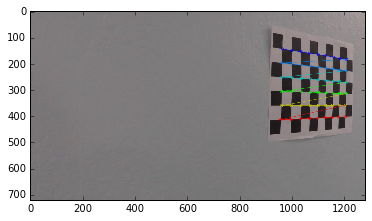

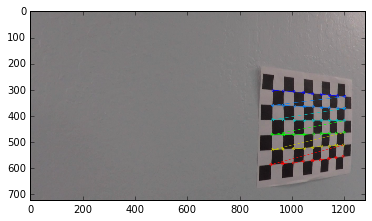

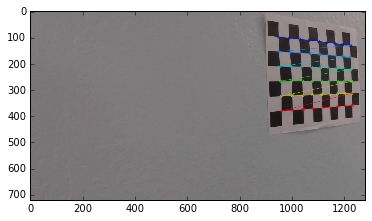

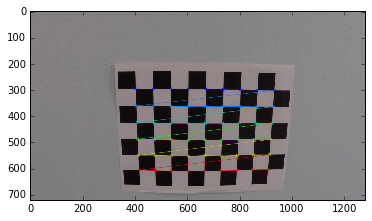

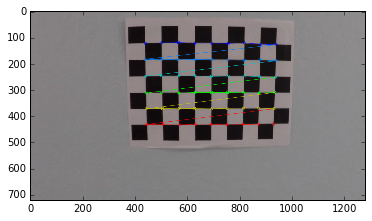

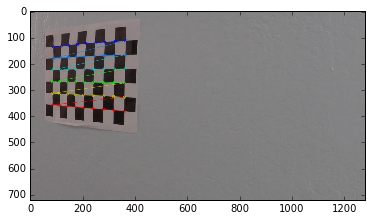

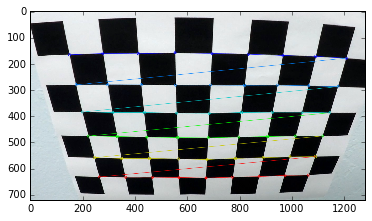

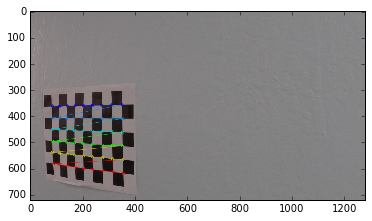

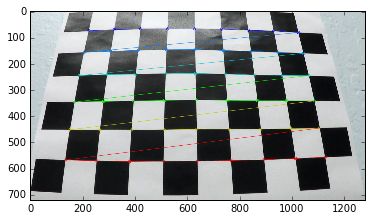

not found
not found


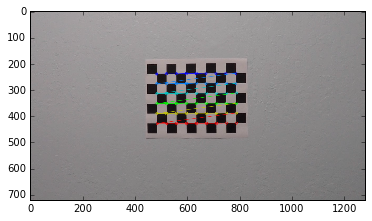

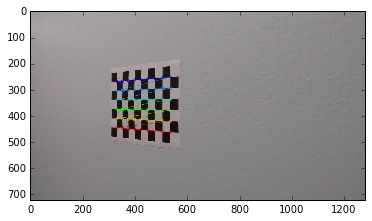

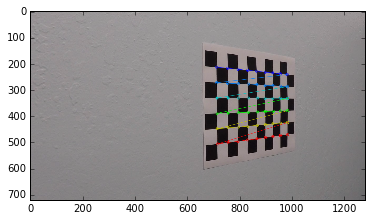

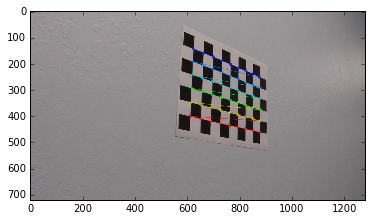

In [2]:
""" Create a camera calibrator instance using chessboard images """

def load_calibration_images():
    return glob.glob('camera_cal/calibration*.jpg')

camera_calibrator = CameraCalibrator(load_calibration_images())

## Step2 - Apply a distortion correction to raw images.

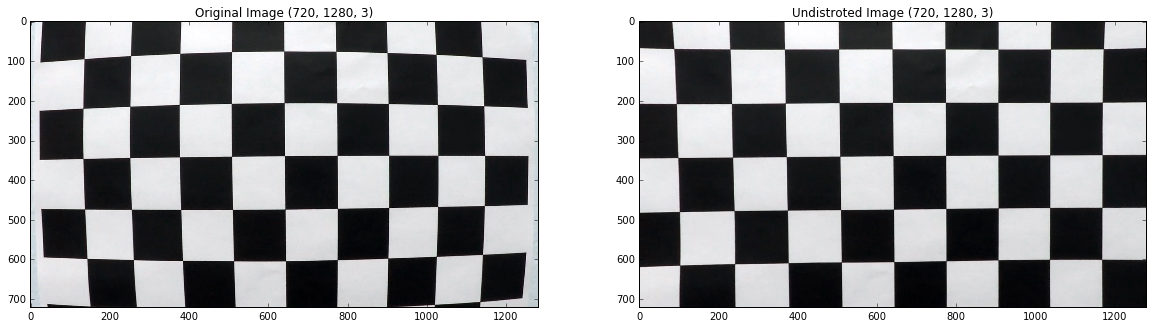

In [3]:
original_img = cv2.imread('camera_cal/calibration1.jpg')
undistorted_img = camera_calibrator.undistort(original_img)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.set_title('Original Image {}'.format(original_img.shape))
ax1.imshow(original_img)
ax2.set_title('Undistroted Image {}'.format(undistorted_img.shape))
ax2.imshow(undistorted_img)

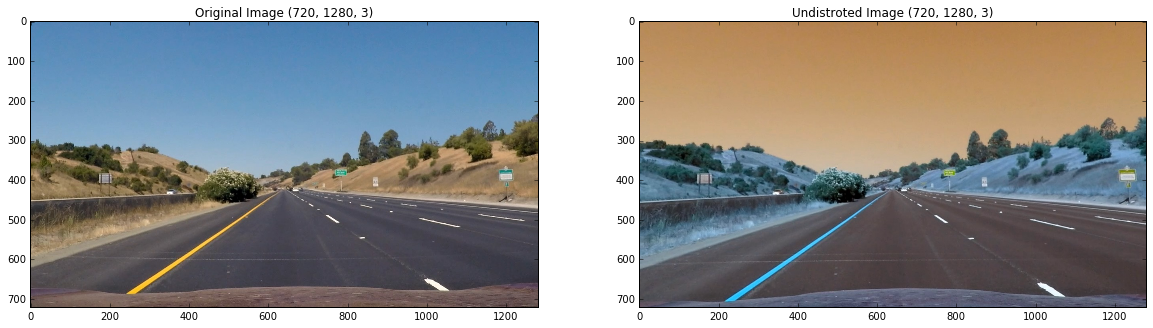

In [4]:
original_img = cv2.imread('test_images/straight_lines1.jpg')
undistorted_img = camera_calibrator.undistort(original_img)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

original_img=cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)
ax1.set_title('Original Image {}'.format(original_img.shape))
ax1.imshow(original_img)
ax2.set_title('Undistroted Image {}'.format(undistorted_img.shape))
ax2.imshow(undistorted_img)

## Step3 - Use color transforms, gradients, etc., to create a thresholded binary image.

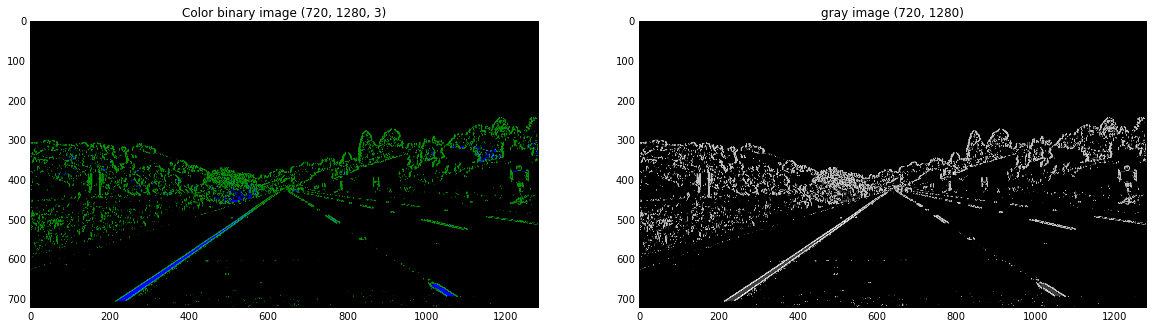

In [5]:
def pipeline(img):
    img = np.copy(img)
    # Convert to HLS color space and separate the S channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s = hls[:,:,2]

    # Grayscale image
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # Sobel x
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
    abssx = np.absolute(sobelx) # Absolute x derivative to accentuate strong verticalish lines
    scale_factor = np.max(abssx)/255 # Will use this to scale back to 8-bit scale
    abssx = (abssx/scale_factor).astype(np.uint8) #rescaling to 8-bit 

    # Threshold x gradient
    retval, sxbinary = cv2.threshold(abssx, 15, 150, cv2.THRESH_BINARY)
    # Threshold color channel
    retval, s_binary = cv2.threshold(s.astype('uint8'), 175, 255, cv2.THRESH_BINARY)

    # Stack each channel to view their individual contributions in green and blue respectively
    # This returns a stack of the two binary images, whose components you can see as different colors
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary))
    
    
    return color_binary

#hls_binary = hls_select(undistorted_img, thresh=(200, 255))   
#create_threshholded_binary_image(undistorted_img)
binary_img = pipeline(undistorted_img)
gray_img = cv2.cvtColor(binary_img, cv2.COLOR_RGB2GRAY)

_, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

ax1.set_title('Color binary image {}'.format(binary_img.shape))
ax1.imshow(binary_img)

ax2.set_title('gray image {}'.format(gray_img.shape))
ax2.imshow(gray_img, cmap='gray')

## Step4 - Apply a perspective transform to rectify binary image ("birds-eye view").

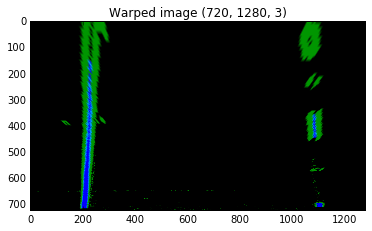

In [6]:
""" Helper methods"""
def draw_lines(img, vertices):
    pts= np.int32([vertices])
    cv2.polylines(img, pts, True, (255,0, 0))

def calc_warp_points(img_height, img_width, x_offset, x_center_offset, y):
    
    xcenter = img_width / 2
    
    src = np.float32([(x_offset, img_height), (xcenter - x_center_offset, y), 
                     (xcenter + x_center_offset, y), (img_width - x_offset, img_height)])
    
    dst = np.float32(
        [(x_offset, img_height), (x_offset,0),
         (img_width - x_offset, 0), (img_width - x_offset, img_height)])
        
    return src, dst

def apply_perspective_tranform(undistorted, x_offset, x_center_offset, y):
    img = np.array(undistorted)
    src, dst = calc_warp_points(img.shape[0], img.shape[1], x_offset, x_center_offset, y)
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    #draw_lines(img, src)
    
    warped = cv2.warpPerspective(img, M, (img.shape[1], img.shape[0]), flags=cv2.INTER_LINEAR)
    return warped, M, Minv
    
    
@interact
def apply_perspective_tranform_test(undistorted=fixed(binary_img), x_offset:(0, 250)=127, \
                                   x_center_offset:(0, 100)=72, y:(0, 600)=459):

    binary_warped, _, _ = apply_perspective_tranform(undistorted, x_offset, x_center_offset, y)
    
    plt.figure()
    plt.title('Warped image {}'.format(binary_warped.shape))
    plt.imshow(binary_warped, cmap='gray')


In [7]:
color_warped, M, Minv = apply_perspective_tranform(binary_img, 127, 72, 459)
warped =  cv2.cvtColor(color_warped, cv2.COLOR_RGB2GRAY)


## Step5 - Detect lane pixels and fit to find the lane boundary.

[(215.0, 1096.0), (217.0, 1093.0), (219.0, 1096.0), (223.0, 1083.0), (226.0, 1084.0), (226.0, 1071.0), (227.0, 1082.0), (229.0, 1060.0), (228.0, 1073.0)]


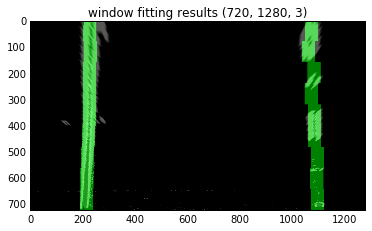

In [65]:
# window settings
window_width = 50 
window_height = 80 # Break image into 9 vertical layers since image height is 720
margin = 100 # How much to slide left and right for searching

def window_mask(width, height, img_ref, center,level):
    output = np.zeros_like(img_ref)
    output[int(img_ref.shape[0]-(level+1)*height):int(img_ref.shape[0]-level*height),max(0,int(center-width/2)):min(int(center+width/2),img_ref.shape[1])] = 1
    return output

def find_window_centroids(warped, window_width, window_height, margin):
    
    window_centroids = [] # Store the (left,right) window centroid positions per level
    window = np.ones(window_width) # Create our window template that we will use for convolutions
    
    # First find the two starting positions for the left and right lane by using np.sum to get the vertical image slice
    # and then np.convolve the vertical image slice with the window template 
    
    # Sum quarter bottom of image to get slice, could use a different ratio
    l_sum = np.sum(warped[int(3*warped.shape[0]/4):,:int(warped.shape[1]/2)], axis=0)
    l_center = np.argmax(np.convolve(window,l_sum))-window_width/2
    r_sum = np.sum(warped[int(3*warped.shape[0]/4):,int(warped.shape[1]/2):], axis=0)
    r_center = np.argmax(np.convolve(window,r_sum))-window_width/2+int(warped.shape[1]/2)
    
    # Add what we found for the first layer
    window_centroids.append((l_center,r_center))
    
    # Go through each layer looking for max pixel locations
    for level in range(1,(int)(warped.shape[0]/window_height)):
        # convolve the window into the vertical slice of the image
        image_layer = np.sum(warped[int(warped.shape[0]-(level+1)*window_height):int(warped.shape[0]-level*window_height),:], axis=0)
        conv_signal = np.convolve(window, image_layer)
        # Find the best left centroid by using past left center as a reference
        # Use window_width/2 as offset because convolution signal reference is at right side of window, not center of window
        offset = window_width/2
        l_min_index = int(max(l_center+offset-margin,0))
        l_max_index = int(min(l_center+offset+margin,warped.shape[1]))
        l_center = np.argmax(conv_signal[l_min_index:l_max_index])+l_min_index-offset
        # Find the best right centroid by using past right center as a reference
        r_min_index = int(max(r_center+offset-margin,0))
        r_max_index = int(min(r_center+offset+margin,warped.shape[1]))
        r_center = np.argmax(conv_signal[r_min_index:r_max_index])+r_min_index-offset
        # Add what we found for that layer
        window_centroids.append((l_center,r_center))

    return window_centroids

window_centroids = find_window_centroids(warped, window_width, window_height, margin)

def test_window_centroid(wc, warped_img):
    # If we found any window centers
    if len(wc) > 0:

        # Points used to draw all the left and right windows
        l_points = np.zeros_like(warped_img)
        r_points = np.zeros_like(warped_img)

        # Go through each level and draw the windows 	
        for level in range(0,len(wc)):
            # Window_mask is a function to draw window areas
            l_mask = window_mask(window_width,window_height,warped_img,wc[level][0],level)
            r_mask = window_mask(window_width,window_height,warped_img,wc[level][1],level)
            # Add graphic points from window mask here to total pixels found 
            l_points[(l_points == 255) | ((l_mask == 1) ) ] = 255
            r_points[(r_points == 255) | ((r_mask == 1) ) ] = 255

        # Draw the results
        template = np.array(r_points+l_points,np.uint8) # add both left and right window pixels together
        zero_channel = np.zeros_like(template) # create a zero color channle 
        template = np.array(cv2.merge((zero_channel,template,zero_channel)),np.uint8) # make window pixels green
        warpage = np.array(cv2.merge((warped_img,warped_img,warped_img)),np.uint8) # making the original road pixels 3 color channels
        output = cv2.addWeighted(warpage, 1, template, 0.5, 0.0) # overlay the orignal road image with window results

        # If no window centers found, just display orginal road image
    else:
        output = np.array(cv2.merge((warped_img,warped_img,warped_img)),np.uint8)
    return output

print(window_centroids)
    
output = test_window_centroid(window_centroids, warped)    
# Display the final results
plt.imshow(output)
plt.title('window fitting results {}'.format(output.shape))
plt.show()


In [14]:
## Step6 - Determine the curvature of the lane and vehicle position with respect to center.

In [66]:
def polyfitLanes(window_centroids):
    leftx = np.array([])
    rightx = np.array([])
    for level in range(0,len(window_centroids)):
        for i in range(window_height):
            leftx = np.append(leftx, window_centroids[level][0])
            rightx = np.append(rightx, window_centroids[level][1])
    # Fit a second order polynomial to pixel positions in each fake lane line

    # Generate some fake data to represent lane-line pixels
    ploty = np.linspace(0, 719, num=720)# to cover same y-range as image
    quadratic_coeff = 3e-4 # arbitrary quadratic coefficient

    leftx = leftx[::-1]  # Reverse to match top-to-bottom in y
    rightx = rightx[::-1]  # Reverse to match top-to-bottom in y


    # Fit a second order polynomial to pixel positions in each fake lane line
    left_fit = np.polyfit(ploty, leftx, 2)
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fit = np.polyfit(ploty, rightx, 2)
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    # Define y-value where we want radius of curvature
    # I'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])    

    return left_fitx, right_fitx, ploty, left_curverad, right_curverad

left_fitx, right_fitx, ploty, left_curverad, right_curverad = polyfitLanes(window_centroids)

## Step7 - Warp the detected lane boundaries back onto the original image.

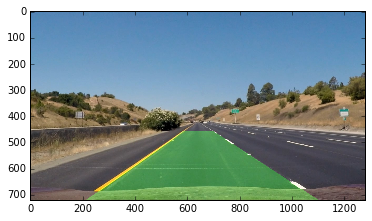

In [29]:
def overlayWarpedImageToOriginalImage(warped, original_img, left_fitx, right_fitx, ploty):
    image = original_img

    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(original_img, 1, newwarp, 0.3, 0)

    return newwarp
    
overlay_img = overlayWarpedImageToOriginalImage(warped, original_img, left_fitx, right_fitx, ploty)
#overlay_img = overlayWarpedImageToOriginalImage(warped, original_img, left_fit_cr, right_fit_cr, ploty)
plt.imshow(overlay_img)

## Image Processing Pipeline

In [63]:
# Global constant
_prev_centroids = None
_centroids_tracker = [] # motion tracker
TRACKER_SIZE = 2
CENTROID_TOLERANCE = 5.0

def create_master_view(mainScreen, screen1, screen2, screen3):
    # middle panel text example
    # using cv2 for drawing text in diagnostic pipeline.
    font = cv2.FONT_HERSHEY_COMPLEX
    middlepanel = np.zeros((120, 1280, 3), dtype=np.uint8)
    cv2.putText(middlepanel, 'Estimated lane curvature: ERROR!', (30, 60), font, 1, (255,0,0), 2)
    cv2.putText(middlepanel, 'Estimated Meters right of center: ERROR!', (30, 90), font, 1, (255,0,0), 2)


    # assemble the screen example
    canvas = np.zeros((1080, 1920, 3), dtype=np.uint8)
    canvas[0:720, 0:1280] = mainScreen
    canvas[0:360, 1280:1760] = cv2.resize(screen1, (480,360), interpolation=cv2.INTER_AREA) 
    canvas[360:720, 1280:1760] = cv2.resize(screen2, (480,360), interpolation=cv2.INTER_AREA)
    canvas[720:1080, 1280:1760] = cv2.resize(screen3, (480,360), interpolation=cv2.INTER_AREA)
    canvas[720:840, 0:1280] = middlepanel
    return canvas

def correct_centroids(prev, cur):
    if prev is None: return cur
    for level in range(0,len(cur)):
        print('centroids', prev[level], cur[level])
        if abs(prev[level][0] - cur[level][0]) > CENTROID_TOLERANCE:
            print('adjusting...')
            cur[level] = prev[level]
    return cur

def process_frame(frame_img, debug=False):
    global _prev_centroids
    
    # Step1: Undistort image using the camera calibration
    undistorted_img = camera_calibrator.undistort(frame_img)
    
    # Step2: Use color transforms, gradients, etc., to create a thresholded binary image 
    binary_img = pipeline(undistorted_img)
    
    # Step3: Apply perspective transformation to create a warped image
    color_warped, M, Minv = apply_perspective_tranform(binary_img, 127, 72, 459)
    warped =  cv2.cvtColor(color_warped, cv2.COLOR_RGB2GRAY)

    # Step4: Get the sliding window polynomials for the left and right line
    # Store the centroids and adjust the centroids based on the history
    window_centroids = find_window_centroids(warped, window_width, window_height, margin)
    #window_centroids = correct_centroids(_prev_centroids, window_centroids)
    left_fitx, right_fitx, ploty, left_curverad, right_curverad = polyfitLanes(window_centroids)
    print(left_curverad, right_curverad)
    
    debug_peak = test_window_centroid(window_centroids, warped)
    
    # Step5: Overlay the warped image to the original image
    overlay = overlayWarpedImageToOriginalImage(warped, frame_img, left_fitx, right_fitx, ploty)
    
    _prev_centroids = window_centroids
    return create_master_view(overlay, binary_img, color_warped, debug_peak)

## Test

In [43]:
def load_test_video(file_name='project_video.mp4'):
    images=[]
    count=0
    
    def convert_frame(img):
        nonlocal count
        #img=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        f="%s - %d" % (file_name, count)
        count += 1
        return (f,img)
    
    clip = VideoFileClip(file_name)
    images = [convert_frame(frame) for frame in clip.iter_frames(progress_bar=True)]
    
    return images

In [15]:
images = load_test_video()

100%|█████████▉| 1260/1261 [00:04<00:00, 284.11it/s]


690.970378424 557.537023497


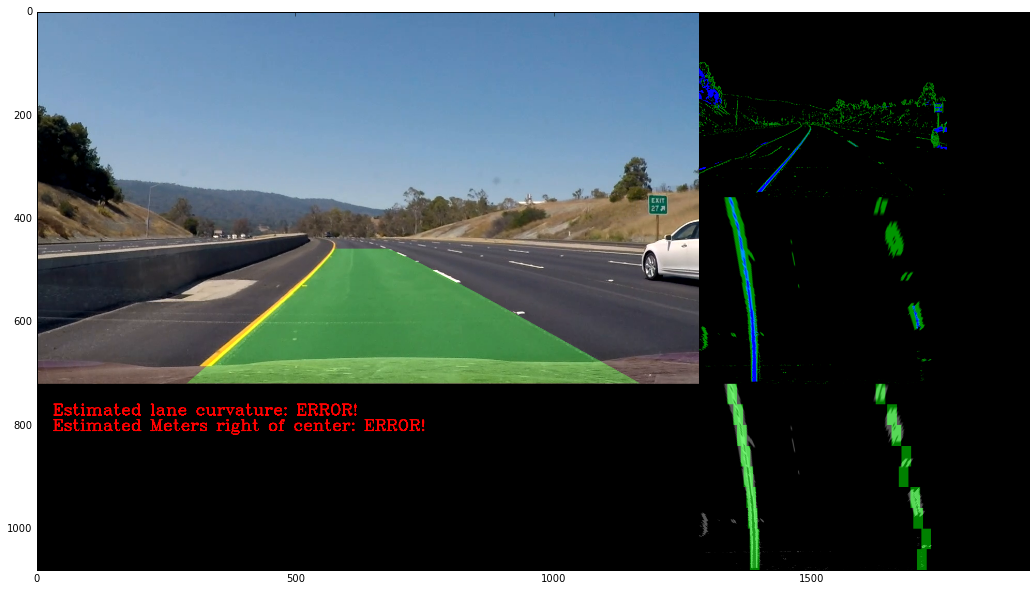

In [64]:

@interact
def testVideoImages(images=fixed(images), i:(0, len(images) - 1)=0):
    file, original_img = images[i]
    output = process_frame(original_img)
    plt.figure(figsize=(20,10))
    plt.imshow(output)


## Step8 - Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

In [39]:
def processVideo(intput_file_name='project_video.mp4', output_file_name='project_video_result.mp4'):
    clip2 = VideoFileClip(intput_file_name).subclip(8, 20)
    #clip2.subclip(frame_start=5, frame_end=15).speedx(2) # works
    yellow_clip = clip2.fl_image(process_frame)
    %time yellow_clip.write_videofile(output_file_name, audio=False)
    
processVideo()

587.732677611 1330.6365339
[MoviePy] >>>> Building video project_video_result.mp4
[MoviePy] Writing video project_video_result.mp4


  0%|          | 1/301 [00:00<00:36,  8.16it/s]

587.732677611 1330.6365339


  1%|          | 2/301 [00:00<00:36,  8.26it/s]

586.392279986 654.408170164


  1%|          | 3/301 [00:00<00:36,  8.26it/s]

578.192774259 332.281031773


  1%|▏         | 4/301 [00:00<00:35,  8.42it/s]

568.031221595 472.370875123


  2%|▏         | 5/301 [00:00<00:34,  8.62it/s]

533.187271794 4822.64936077


  2%|▏         | 6/301 [00:00<00:33,  8.68it/s]

526.404530515 523.740624222


  2%|▏         | 7/301 [00:00<00:33,  8.72it/s]

507.307697052 612.521289356


  3%|▎         | 8/301 [00:00<00:33,  8.82it/s]

481.799059335 344.725773629


  3%|▎         | 9/301 [00:01<00:33,  8.78it/s]

476.910382747 256.939302748


  3%|▎         | 10/301 [00:01<00:33,  8.71it/s]

503.845907916 436.414811356


  4%|▎         | 11/301 [00:01<00:35,  8.08it/s]

522.152953962 287.785763187
498.501452194 485.960253355


  4%|▍         | 13/301 [00:01<00:37,  7.64it/s]

482.463568935 2127.31970344


  5%|▍         | 14/301 [00:01<00:36,  7.90it/s]

448.389032859 668.64159112


  5%|▍         | 15/301 [00:01<00:35,  8.04it/s]

432.102076917 365.808976782


  5%|▌         | 16/301 [00:01<00:35,  7.95it/s]

445.679084649 516.849067174


  6%|▌         | 17/301 [00:02<00:36,  7.69it/s]

459.939553298 449.62058731


  6%|▌         | 18/301 [00:02<00:38,  7.36it/s]

471.248068299 644.743694976


  6%|▋         | 19/301 [00:02<00:36,  7.63it/s]

478.439487213 827.868544024


  7%|▋         | 20/301 [00:02<00:35,  7.82it/s]

496.106436722 616.678832346


  7%|▋         | 21/301 [00:02<00:34,  8.07it/s]

506.306285721 658.280844085


  7%|▋         | 22/301 [00:02<00:34,  8.17it/s]

538.466943938 581.899339004


  8%|▊         | 23/301 [00:02<00:33,  8.24it/s]

535.124323332 372.617824741


  8%|▊         | 24/301 [00:02<00:32,  8.39it/s]

523.475382385 650.932573496


  8%|▊         | 25/301 [00:03<00:33,  8.32it/s]

537.067692842 7.14512478742e+16


  9%|▊         | 26/301 [00:03<00:32,  8.46it/s]

575.304949182 310.43934889


  9%|▉         | 27/301 [00:03<00:32,  8.48it/s]

598.272055717 457.423259662


  9%|▉         | 28/301 [00:03<00:32,  8.53it/s]

580.148632717 745.099241114


 10%|▉         | 29/301 [00:03<00:31,  8.60it/s]

590.078228784 713.391786063


 10%|▉         | 30/301 [00:03<00:31,  8.62it/s]

620.908134525 961.633061695


 10%|█         | 31/301 [00:03<00:31,  8.49it/s]

643.311444127 401.871980675


 11%|█         | 32/301 [00:03<00:31,  8.56it/s]

632.302005026 540.556753585


 11%|█         | 33/301 [00:03<00:31,  8.42it/s]

689.652997234 1466.75103084


 11%|█▏        | 34/301 [00:04<00:31,  8.43it/s]

720.901389549 790.700102863


 12%|█▏        | 35/301 [00:04<00:31,  8.52it/s]

710.003404683 293.743586302


 12%|█▏        | 36/301 [00:04<00:31,  8.45it/s]

681.89373493 502.211375495


 12%|█▏        | 37/301 [00:04<00:31,  8.48it/s]

665.649949433 398.021291949


 13%|█▎        | 38/301 [00:04<00:31,  8.39it/s]

626.905967456 268.05980051


 13%|█▎        | 39/301 [00:04<00:30,  8.47it/s]

608.104008779 390.531115692


 13%|█▎        | 40/301 [00:04<00:30,  8.59it/s]

592.090629046 650.176096289


 14%|█▎        | 41/301 [00:04<00:30,  8.60it/s]

583.736972923 358.973741409


 14%|█▍        | 42/301 [00:05<00:30,  8.60it/s]

616.439426491 612.97812175


 14%|█▍        | 43/301 [00:05<00:30,  8.60it/s]

554.631285114 312.986235324


 15%|█▍        | 44/301 [00:05<00:30,  8.54it/s]

561.252100991 549.595682243


 15%|█▍        | 45/301 [00:05<00:30,  8.53it/s]

547.012652972 391.436716721


 15%|█▌        | 46/301 [00:05<00:30,  8.44it/s]

515.665721987 333.259602996


 16%|█▌        | 47/301 [00:05<00:30,  8.45it/s]

513.106919289 408.874937007


 16%|█▌        | 48/301 [00:05<00:29,  8.48it/s]

541.578678723 234.228657707


 16%|█▋        | 49/301 [00:05<00:29,  8.58it/s]

545.571947072 244.330733174


 17%|█▋        | 50/301 [00:05<00:29,  8.57it/s]

543.851116369 303.071279413


 17%|█▋        | 51/301 [00:06<00:29,  8.59it/s]

564.318939711 412.344718604


 17%|█▋        | 52/301 [00:06<00:29,  8.55it/s]

556.72766437 473.284117041


 18%|█▊        | 53/301 [00:06<00:29,  8.54it/s]

563.707985109 399.02025443


 18%|█▊        | 54/301 [00:06<00:29,  8.48it/s]

602.088223581 882.222240294


 18%|█▊        | 55/301 [00:06<00:29,  8.44it/s]

577.879420818 456.321326519


 19%|█▊        | 56/301 [00:06<00:29,  8.42it/s]

578.206584844 654.5404316


 19%|█▉        | 57/301 [00:06<00:28,  8.45it/s]

587.402702857 332.814693221


 19%|█▉        | 58/301 [00:06<00:28,  8.47it/s]

632.273980812 312.324358533


 20%|█▉        | 59/301 [00:07<00:28,  8.55it/s]

675.629268262 274.868668621


 20%|█▉        | 60/301 [00:07<00:28,  8.58it/s]

718.821334842 237.619486195


 20%|██        | 61/301 [00:07<00:27,  8.63it/s]

780.076914671 268.221940286


 21%|██        | 62/301 [00:07<00:27,  8.63it/s]

742.559725793 298.975214615


 21%|██        | 63/301 [00:07<00:27,  8.56it/s]

732.57438031 430.833303002


 21%|██▏       | 64/301 [00:07<00:27,  8.51it/s]

698.45413291 406.756983647


 22%|██▏       | 65/301 [00:07<00:27,  8.46it/s]

672.578408647 594.580906278


 22%|██▏       | 66/301 [00:07<00:27,  8.54it/s]

693.771958975 1353.57283896


 22%|██▏       | 67/301 [00:07<00:27,  8.61it/s]

659.296146272 497.116184694


 23%|██▎       | 68/301 [00:08<00:26,  8.65it/s]

670.834905676 641.380118178


 23%|██▎       | 69/301 [00:08<00:26,  8.69it/s]

678.755898013 1363.37823062


 23%|██▎       | 70/301 [00:08<00:26,  8.63it/s]

697.519072576 1127.4232663


 24%|██▎       | 71/301 [00:08<00:26,  8.61it/s]

676.102790012 381.577755703


 24%|██▍       | 72/301 [00:08<00:26,  8.62it/s]

680.114291255 525.871023165


 24%|██▍       | 73/301 [00:08<00:26,  8.51it/s]

666.108392691 293.050603238


 25%|██▍       | 74/301 [00:08<00:27,  8.22it/s]

651.447824179 352.070720581


 25%|██▍       | 75/301 [00:08<00:27,  8.31it/s]

677.454742403 539.114089802


 25%|██▌       | 76/301 [00:09<00:26,  8.43it/s]

735.207986875 673.984428623


 26%|██▌       | 77/301 [00:09<00:26,  8.52it/s]

712.922203235 728.754660207


 26%|██▌       | 78/301 [00:09<00:25,  8.65it/s]

745.804947306 2595.87770666


 26%|██▌       | 79/301 [00:09<00:25,  8.68it/s]

795.70938901 537.350116628


 27%|██▋       | 80/301 [00:09<00:25,  8.71it/s]

864.161407505 861.553906137


 27%|██▋       | 81/301 [00:09<00:25,  8.78it/s]

924.393732695 3521.18578129


 27%|██▋       | 82/301 [00:09<00:24,  8.77it/s]

967.630641118 431.353288249


 28%|██▊       | 83/301 [00:09<00:24,  8.74it/s]

1030.26679552 442.826540819


 28%|██▊       | 84/301 [00:09<00:25,  8.62it/s]

1033.35680875 641.682383362


 28%|██▊       | 85/301 [00:10<00:25,  8.51it/s]

1026.18088433 875.987211478


 29%|██▊       | 86/301 [00:10<00:25,  8.57it/s]

1077.48547642 3793.96467544


 29%|██▉       | 87/301 [00:10<00:24,  8.64it/s]

1141.70874628 371.459949539


 29%|██▉       | 88/301 [00:10<00:24,  8.65it/s]

1128.01573468 571.170708731


 30%|██▉       | 89/301 [00:10<00:24,  8.68it/s]

1252.28659083 2633.33686912


 30%|██▉       | 90/301 [00:10<00:24,  8.75it/s]

1256.8539287 16438.9192448


 30%|███       | 91/301 [00:10<00:24,  8.74it/s]

1244.77534934 744.77063463


 31%|███       | 92/301 [00:10<00:24,  8.62it/s]

1348.63544784 1083.40717593


 31%|███       | 93/301 [00:11<00:24,  8.60it/s]

1334.71825689 8771.74788465


 31%|███       | 94/301 [00:11<00:24,  8.44it/s]

1331.29113932 485.625516815


 32%|███▏      | 95/301 [00:11<00:24,  8.48it/s]

1395.94758817 783.168034916


 32%|███▏      | 96/301 [00:11<00:24,  8.41it/s]

1452.80533015 545.049207675


 32%|███▏      | 97/301 [00:11<00:24,  8.46it/s]

1548.48778883 443.754141533


 33%|███▎      | 98/301 [00:11<00:23,  8.53it/s]

1381.03511776 453.081258837


 33%|███▎      | 99/301 [00:11<00:23,  8.62it/s]

1484.0578125 639.738195887


 33%|███▎      | 100/301 [00:11<00:23,  8.68it/s]

1302.76733694 579.816446802


 34%|███▎      | 101/301 [00:11<00:23,  8.67it/s]

1348.62814169 2073.88403289


 34%|███▍      | 102/301 [00:12<00:22,  8.77it/s]

1306.04796582 2343.36805752


 34%|███▍      | 103/301 [00:12<00:22,  8.83it/s]

1338.15016037 808.865488689


 35%|███▍      | 104/301 [00:12<00:22,  8.83it/s]

1405.4214158 1108.85033559


 35%|███▍      | 105/301 [00:12<00:22,  8.80it/s]

1501.28235652 25874.1708062


 35%|███▌      | 106/301 [00:12<00:21,  8.89it/s]

1715.39719617 2667.85886453


 36%|███▌      | 107/301 [00:12<00:21,  8.93it/s]

1904.9394383 1624.76343445


 36%|███▌      | 108/301 [00:12<00:21,  8.90it/s]

2219.70527739 1364.82932814


 36%|███▌      | 109/301 [00:12<00:21,  8.87it/s]

2566.70484618 1114.92180462


 37%|███▋      | 110/301 [00:12<00:21,  8.94it/s]

2972.36292939 966.004756362


 37%|███▋      | 111/301 [00:13<00:21,  8.96it/s]

3144.03014221 1707.69289894


 37%|███▋      | 112/301 [00:13<00:21,  8.88it/s]

5531.45532077 2688.43492892


 38%|███▊      | 113/301 [00:13<00:21,  8.94it/s]

8692.30464132 1964.02806744


 38%|███▊      | 114/301 [00:13<00:20,  8.91it/s]

26522.6190156 9768.91881203


 38%|███▊      | 115/301 [00:13<00:21,  8.81it/s]

11004.0792949 1762.43985732


 39%|███▊      | 116/301 [00:13<00:21,  8.72it/s]

51719.0962632 3682.17599273


 39%|███▉      | 117/301 [00:13<00:21,  8.67it/s]

54441.1574093 2028.26191286


 39%|███▉      | 118/301 [00:13<00:21,  8.71it/s]

6385.07727008 623.163029174


 40%|███▉      | 119/301 [00:13<00:20,  8.69it/s]

4925.63905463 830.171452043


 40%|███▉      | 120/301 [00:14<00:20,  8.63it/s]

3506.38419008 632.272983374


 40%|████      | 121/301 [00:14<00:20,  8.63it/s]

3734.23835795 600.352077451


 41%|████      | 122/301 [00:14<00:20,  8.68it/s]

3694.23031693 765.07538102


 41%|████      | 123/301 [00:14<00:20,  8.75it/s]

2946.96447174 1082.03005497


 41%|████      | 124/301 [00:14<00:20,  8.76it/s]

3402.57902367 849.945192038


 42%|████▏     | 125/301 [00:14<00:19,  8.83it/s]

3845.28594207 5251.80369627


 42%|████▏     | 126/301 [00:14<00:19,  8.86it/s]

4170.8973595 1341.36085748


 42%|████▏     | 127/301 [00:14<00:19,  8.86it/s]

5021.27482574 997.487288066


 43%|████▎     | 128/301 [00:14<00:19,  8.86it/s]

5561.19848703 1444.67406191


 43%|████▎     | 129/301 [00:15<00:19,  8.90it/s]

14568.7903418 5532.23114574


 43%|████▎     | 130/301 [00:15<00:19,  8.86it/s]

6989.09615188 1191.72301483


 44%|████▎     | 131/301 [00:15<00:19,  8.87it/s]

7777.37669387 1056.5699877


 44%|████▍     | 132/301 [00:15<00:18,  8.92it/s]

6157.18211704 511.52717539


 44%|████▍     | 133/301 [00:15<00:18,  8.94it/s]

6269.19226922 680.515098258


 45%|████▍     | 134/301 [00:15<00:18,  8.89it/s]

10042.9778036 859.837864577


 45%|████▍     | 135/301 [00:15<00:18,  8.97it/s]

8275.35950498 1426.88559437


 45%|████▌     | 136/301 [00:15<00:18,  8.98it/s]

7388.51231961 1212.66705447


 46%|████▌     | 137/301 [00:16<00:18,  8.94it/s]

16957.3520443 17245.1707756


 46%|████▌     | 138/301 [00:16<00:18,  8.99it/s]

15438.7626065 968.920111512


 46%|████▌     | 139/301 [00:16<00:17,  9.03it/s]

4104.71080859 1759.16872999


 47%|████▋     | 140/301 [00:16<00:17,  8.95it/s]

4040.59082376 6195.22202184


 47%|████▋     | 141/301 [00:16<00:17,  8.94it/s]

3788.9771943 15918.9465401


 47%|████▋     | 142/301 [00:16<00:17,  8.92it/s]

3015.74177069 1959.40160771


 48%|████▊     | 143/301 [00:16<00:17,  8.89it/s]

2456.96847985 147830.922975


 48%|████▊     | 144/301 [00:16<00:17,  8.82it/s]

2334.94841036 1937.05441415


 48%|████▊     | 145/301 [00:16<00:17,  8.67it/s]

1948.00312583 3163.48589728


 49%|████▊     | 146/301 [00:17<00:17,  8.69it/s]

2077.09432741 10142.6858756


 49%|████▉     | 147/301 [00:17<00:17,  8.70it/s]

2278.38052815 2411.40693324


 49%|████▉     | 148/301 [00:17<00:17,  8.78it/s]

2686.71275683 1518.9389738


 50%|████▉     | 149/301 [00:17<00:17,  8.84it/s]

4256.73252366 5747.37954472


 50%|████▉     | 150/301 [00:17<00:17,  8.80it/s]

5331.89252667 965.924087486


 50%|█████     | 151/301 [00:17<00:17,  8.78it/s]

6588.4982317 2516.87683744


 50%|█████     | 152/301 [00:17<00:17,  8.68it/s]

19892.5554162 8019.23900488


 51%|█████     | 153/301 [00:17<00:17,  8.65it/s]

6465.25735548 15440.1133214


 51%|█████     | 154/301 [00:17<00:17,  8.47it/s]

5277.78181135 7284.97685243


 51%|█████▏    | 155/301 [00:18<00:17,  8.55it/s]

3554.87510038 773.536520647


 52%|█████▏    | 156/301 [00:18<00:16,  8.63it/s]

3616.99479995 721.774357485


 52%|█████▏    | 157/301 [00:18<00:16,  8.74it/s]

3097.27453364 2329.74092084


 52%|█████▏    | 158/301 [00:18<00:16,  8.80it/s]

4680.72220168 2151.54643495


 53%|█████▎    | 159/301 [00:18<00:16,  8.86it/s]

5146.49828998 796.316041923


 53%|█████▎    | 160/301 [00:18<00:16,  8.81it/s]

23509.3136272 1382.87326335


 53%|█████▎    | 161/301 [00:18<00:15,  8.79it/s]

26523.0479061 4328.85988467


 54%|█████▍    | 162/301 [00:18<00:15,  8.69it/s]

2004.63754276 863.070075047


 54%|█████▍    | 163/301 [00:18<00:16,  8.56it/s]

2060.55651771 5715.55155294


 54%|█████▍    | 164/301 [00:19<00:16,  8.52it/s]

1501.31417018 9854.8720024


 55%|█████▍    | 165/301 [00:19<00:15,  8.56it/s]

1277.07867182 43105.169118


 55%|█████▌    | 166/301 [00:19<00:15,  8.60it/s]

995.653940112 1546.21588607


 55%|█████▌    | 167/301 [00:19<00:15,  8.58it/s]

975.028555475 22013.8185445


 56%|█████▌    | 168/301 [00:19<00:15,  8.66it/s]

900.388513182 1208.57304995


 56%|█████▌    | 169/301 [00:19<00:15,  8.75it/s]

817.810613161 1079.73298768


 56%|█████▋    | 170/301 [00:19<00:14,  8.81it/s]

852.155713771 1660.3629796


 57%|█████▋    | 171/301 [00:19<00:14,  8.90it/s]

913.026247986 4171.52473918


 57%|█████▋    | 172/301 [00:20<00:14,  8.87it/s]

1036.49538408 1557.82322053


 57%|█████▋    | 173/301 [00:20<00:14,  8.88it/s]

1206.99856102 2701.39202051


 58%|█████▊    | 174/301 [00:20<00:14,  8.94it/s]

1375.50790389 722.867595664


 58%|█████▊    | 175/301 [00:20<00:14,  8.98it/s]

1940.71640332 24060.0059286


 58%|█████▊    | 176/301 [00:20<00:14,  8.93it/s]

2693.93277571 3579.9323722


 59%|█████▉    | 177/301 [00:20<00:13,  8.92it/s]

2905.82123105 3233.53021361


 59%|█████▉    | 178/301 [00:20<00:13,  8.95it/s]

4618.39393353 3134.94095464


 59%|█████▉    | 179/301 [00:20<00:13,  8.95it/s]

6990.01284507 9949.1643595


 60%|█████▉    | 180/301 [00:20<00:13,  8.72it/s]

49263.8348359 3060.37424357


 60%|██████    | 181/301 [00:21<00:13,  8.76it/s]

19894.3817993 4537.02876118


 60%|██████    | 182/301 [00:21<00:13,  8.78it/s]

206903.213104 1603.71101704


 61%|██████    | 183/301 [00:21<00:13,  8.87it/s]

33372.1923019 3694.62400117


 61%|██████    | 184/301 [00:21<00:13,  8.93it/s]

29558.1401467 1639.28913071


 61%|██████▏   | 185/301 [00:21<00:13,  8.87it/s]

27223.513708 3115.94618891


 62%|██████▏   | 186/301 [00:21<00:12,  8.94it/s]

41379.4689815 886.598981951


 62%|██████▏   | 187/301 [00:21<00:12,  8.97it/s]

39785.8445938 3888.8759658


 62%|██████▏   | 188/301 [00:21<00:12,  8.87it/s]

51721.4468781 68967.5924656


 63%|██████▎   | 189/301 [00:21<00:12,  8.92it/s]

94037.3965018 1214.51998754


 63%|██████▎   | 190/301 [00:22<00:12,  8.99it/s]

129299.720357 2914.62654052


 63%|██████▎   | 191/301 [00:22<00:12,  8.94it/s]

14991.1188718 1235.15929924


 64%|██████▍   | 192/301 [00:22<00:12,  8.93it/s]

18471.1342397 962.428738407


 64%|██████▍   | 193/301 [00:22<00:12,  8.94it/s]

73884.8559847 6717.30603357


 64%|██████▍   | 194/301 [00:22<00:11,  8.94it/s]

57465.6904128 685.813456376


 65%|██████▍   | 195/301 [00:22<00:11,  8.93it/s]

7284.48828494 3668.19839567


 65%|██████▌   | 196/301 [00:22<00:11,  8.93it/s]

4024.96797945 2566.82623556


 65%|██████▌   | 197/301 [00:22<00:11,  8.95it/s]

3448.03969047 2219.75711071


 66%|██████▌   | 198/301 [00:22<00:11,  8.92it/s]

3153.70779068 2309.0018476


 66%|██████▌   | 199/301 [00:23<00:11,  8.98it/s]

3542.47477582 5747.7974364


 66%|██████▋   | 200/301 [00:23<00:11,  8.98it/s]

4328.01896954 2480.5626523


 67%|██████▋   | 201/301 [00:23<00:11,  8.97it/s]

4040.59734049 904.757759648


 67%|██████▋   | 202/301 [00:23<00:11,  8.88it/s]

4458.57096779 7720.1289399


 67%|██████▋   | 203/301 [00:23<00:10,  8.92it/s]

8840.884055 408.361279322


 68%|██████▊   | 204/301 [00:23<00:10,  8.95it/s]

11493.1331552 1650.1963925


 68%|██████▊   | 205/301 [00:23<00:10,  8.91it/s]

11754.4223459 34483.407649


 68%|██████▊   | 206/301 [00:23<00:10,  8.88it/s]

7336.16330671 675.042145941


 69%|██████▉   | 207/301 [00:23<00:10,  8.90it/s]

8917.204651 3337.17263247


 69%|██████▉   | 208/301 [00:24<00:10,  8.87it/s]

4517.07281522 1421.55349516


 69%|██████▉   | 209/301 [00:24<00:10,  8.84it/s]

4788.93019404 4040.97201644


 70%|██████▉   | 210/301 [00:24<00:10,  8.82it/s]

4170.96640158 1933.46297356


 70%|███████   | 211/301 [00:24<00:10,  8.84it/s]

5359.52868491 19893.8036613


 70%|███████   | 212/301 [00:24<00:10,  8.86it/s]

8840.87915274 949.203996542


 71%|███████   | 213/301 [00:24<00:09,  8.90it/s]

18471.1110393 1196.30989957


 71%|███████   | 214/301 [00:24<00:09,  8.87it/s]

103438.591972 3519.20878572


 71%|███████▏  | 215/301 [00:24<00:09,  8.83it/s]

129299.593037 3448.97659936


 72%|███████▏  | 216/301 [00:24<00:09,  8.79it/s]

86198.775718 1459.54985686


 72%|███████▏  | 217/301 [00:25<00:09,  8.77it/s]

21549.8462521 12931.3160963


 72%|███████▏  | 218/301 [00:25<00:09,  8.78it/s]

7133.78310737 2248.67445793


 73%|███████▎  | 219/301 [00:25<00:09,  8.80it/s]

5621.72095089 6989.84537356


 73%|███████▎  | 220/301 [00:25<00:09,  8.72it/s]

5387.53388804 3681.41100261


 73%|███████▎  | 221/301 [00:25<00:09,  8.70it/s]

3471.20740968 2535.32088667


 74%|███████▍  | 222/301 [00:25<00:09,  8.71it/s]

4478.01808396 2560.54753435


 74%|███████▍  | 223/301 [00:25<00:08,  8.70it/s]

2788.23289523 22490.5497087


 74%|███████▍  | 224/301 [00:25<00:08,  8.73it/s]

5277.54538568 2293.56394493


 75%|███████▍  | 225/301 [00:25<00:08,  8.77it/s]

4597.32734364 1271.2348423


 75%|███████▌  | 226/301 [00:26<00:08,  8.87it/s]

3402.60457647 11755.3008461


 75%|███████▌  | 227/301 [00:26<00:08,  8.89it/s]

10241.4106534 7037.80034019


 76%|███████▌  | 228/301 [00:26<00:08,  8.91it/s]

17239.6993795 715.734338559


 76%|███████▌  | 229/301 [00:26<00:08,  8.96it/s]

15438.5366476 20689.2990021


 76%|███████▋  | 230/301 [00:26<00:07,  8.94it/s]

25228.8282067 616.824612944


 77%|███████▋  | 231/301 [00:26<00:07,  8.99it/s]

15913.5877785 38313.9646577


 77%|███████▋  | 232/301 [00:26<00:07,  9.00it/s]

9851.25641059 2554.64011779


 77%|███████▋  | 233/301 [00:26<00:07,  8.87it/s]

26522.7290154 2865.32872055


 78%|███████▊  | 234/301 [00:26<00:07,  8.83it/s]

103438.57784 2803.26266203


 78%|███████▊  | 235/301 [00:27<00:07,  8.77it/s]

19891.9850255 8917.30624673


 78%|███████▊  | 236/301 [00:27<00:07,  8.70it/s]

7550.28359154 1546.17653167


 79%|███████▊  | 237/301 [00:27<00:07,  8.68it/s]

4221.99122183 4383.72329895


 79%|███████▉  | 238/301 [00:27<00:07,  8.71it/s]

4659.41253277 3483.63524339


 79%|███████▉  | 239/301 [00:27<00:07,  8.80it/s]

2214.98770583 738.467332897


 80%|███████▉  | 240/301 [00:27<00:06,  8.84it/s]

1993.04208074 1962.78403844


 80%|████████  | 241/301 [00:27<00:06,  8.83it/s]

1521.20095032 2541.54473808


 80%|████████  | 242/301 [00:27<00:06,  8.84it/s]

1880.72167072 887.20253341


 81%|████████  | 243/301 [00:28<00:06,  8.58it/s]

2541.52334405 2367.01554207


 81%|████████  | 244/301 [00:28<00:06,  8.60it/s]

2052.38251534 1488.32061908


 81%|████████▏ | 245/301 [00:28<00:06,  8.64it/s]

1843.87655816 2196.14018556


 82%|████████▏ | 246/301 [00:28<00:06,  8.72it/s]

1974.0447094 1247.75263742


 82%|████████▏ | 247/301 [00:28<00:06,  8.79it/s]

2068.768187 1322.75474437


 82%|████████▏ | 248/301 [00:28<00:05,  8.84it/s]

1159.66691497 1080.94540826


 83%|████████▎ | 249/301 [00:28<00:05,  8.83it/s]

1817.89441598 3530.56813512


 83%|████████▎ | 250/301 [00:28<00:05,  8.84it/s]

1887.56073606 1341.64447075


 83%|████████▎ | 251/301 [00:28<00:05,  8.93it/s]

2592.48462274 1450.74759627


 84%|████████▎ | 252/301 [00:29<00:05,  8.86it/s]

2486.5323221 633.938280043


 84%|████████▍ | 253/301 [00:29<00:05,  8.80it/s]

2632.04937952 2579.54560245


 84%|████████▍ | 254/301 [00:29<00:05,  8.75it/s]

2535.31749454 8410.96205977


 85%|████████▍ | 255/301 [00:29<00:05,  8.75it/s]

2881.41142771 743.158018467


 85%|████████▌ | 256/301 [00:29<00:05,  8.66it/s]

3579.44415966 1296.21865665


 85%|████████▌ | 257/301 [00:29<00:05,  8.67it/s]

4926.10415255 3518.97413035


 86%|████████▌ | 258/301 [00:29<00:04,  8.70it/s]

3775.38535593 1028.14649369


 86%|████████▌ | 259/301 [00:29<00:04,  8.81it/s]

5332.60499486 5844.69227349


 86%|████████▋ | 260/301 [00:29<00:04,  8.85it/s]

5844.67570252 7957.16293371


 87%|████████▋ | 261/301 [00:30<00:04,  8.84it/s]

24059.3890981 1032.93622048


 87%|████████▋ | 262/301 [00:30<00:04,  8.90it/s]

22011.2205328 4275.15216675


 87%|████████▋ | 263/301 [00:30<00:04,  8.93it/s]

11244.9152267 451.589902304


 88%|████████▊ | 264/301 [00:30<00:04,  8.88it/s]

26526.83477 831.930162715


 88%|████████▊ | 265/301 [00:30<00:04,  8.82it/s]

6506.7944434 25861.6227297


 88%|████████▊ | 266/301 [00:30<00:03,  8.78it/s]

5305.79886417 9319.62126835


 89%|████████▊ | 267/301 [00:30<00:03,  8.81it/s]

3107.12951699 4459.54381925


 89%|████████▉ | 268/301 [00:30<00:03,  8.74it/s]

2882.08346489 21551.2932813


 89%|████████▉ | 269/301 [00:30<00:03,  8.79it/s]

2744.40336174 5532.40786996


 90%|████████▉ | 270/301 [00:31<00:03,  8.62it/s]

2288.93079763 576.955705693


 90%|█████████ | 271/301 [00:31<00:03,  8.66it/s]

5945.47872684 4517.4853973


 90%|█████████ | 272/301 [00:31<00:03,  8.66it/s]

3860.14150237 1490.96056485


 91%|█████████ | 273/301 [00:31<00:03,  8.68it/s]

6761.19965342 873.219906628


 91%|█████████ | 274/301 [00:31<00:03,  8.67it/s]

11755.1078024 1744.76237641


 91%|█████████▏| 275/301 [00:31<00:03,  8.60it/s]

19155.6608826 410.649448788


 92%|█████████▏| 276/301 [00:31<00:02,  8.53it/s]

6424.74992833 1133.54459618


 92%|█████████▏| 277/301 [00:31<00:02,  8.55it/s]

8917.08770578 15913.6855995


 92%|█████████▏| 278/301 [00:32<00:02,  8.60it/s]

3436.51321026 542.923050748


 93%|█████████▎| 279/301 [00:32<00:02,  8.58it/s]

5224.15720347 3874.14388804


 93%|█████████▎| 280/301 [00:32<00:02,  8.70it/s]

4536.80245023 1161.16628482


 93%|█████████▎| 281/301 [00:32<00:02,  8.77it/s]

3542.41773469 2810.82117193


 94%|█████████▎| 282/301 [00:32<00:02,  8.84it/s]

4009.26054857 1373.98702824


 94%|█████████▍| 283/301 [00:32<00:02,  8.82it/s]

5359.50552238 5561.32301018


 94%|█████████▍| 284/301 [00:32<00:01,  8.75it/s]

17834.25479 1619.03119884


 95%|█████████▍| 285/301 [00:32<00:01,  8.70it/s]

5652.36591437 1090.14289138


 95%|█████████▌| 286/301 [00:32<00:01,  8.70it/s]

19155.7220735 4383.20084686


 95%|█████████▌| 287/301 [00:33<00:01,  8.73it/s]

22487.4505525 472.579685763


 96%|█████████▌| 288/301 [00:33<00:01,  8.65it/s]

5172.075251 2081.37665967


 96%|█████████▌| 289/301 [00:33<00:01,  8.71it/s]

4723.38211651 64650.4188547


 96%|█████████▋| 290/301 [00:33<00:01,  8.78it/s]

8917.57448938 4811.51029579


 97%|█████████▋| 291/301 [00:33<00:01,  8.73it/s]

4056.53627812 2383.38152747


 97%|█████████▋| 292/301 [00:33<00:01,  8.79it/s]

6588.62817402 29553.8792568


 97%|█████████▋| 293/301 [00:33<00:00,  8.67it/s]

4328.04253486 2645.47831841


 98%|█████████▊| 294/301 [00:33<00:00,  8.74it/s]

11754.6072844 897.53711329


 98%|█████████▊| 295/301 [00:33<00:00,  8.83it/s]

11493.313198 1263.11655801


 98%|█████████▊| 296/301 [00:34<00:00,  8.86it/s]

5591.30888372 1240.38069451


 99%|█████████▊| 297/301 [00:34<00:00,  8.92it/s]

7605.87385883 2498.55544621


 99%|█████████▉| 298/301 [00:34<00:00,  8.90it/s]

9851.51005541 4497.32344091


 99%|█████████▉| 299/301 [00:34<00:00,  8.96it/s]

10448.5177184 1086.87174339


100%|█████████▉| 300/301 [00:34<00:00,  9.00it/s]

9153.86591021 5198.04091123


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_result.mp4 

CPU times: user 45.1 s, sys: 5.45 s, total: 50.6 s
Wall time: 35.5 s
